# Notebook de referência 

Nome: Matheus Lindino

## Instruções:

O objetivo desse colab é entender o comportamento das seguintes variáveis importantes de treinamento:
   - Batch size
   - Learning rate
   - FLOPs (computação gasta no treinamento)
   - Tamanho do modelo

Para tanto, iremos treinar e medir a loss e acurácia de 3 modelos BERT para análise de sentimento (classificação binária) usando o dataset do IMDB (20k/5k amostras de treino/validação).

Iremos fazer os 3 x 5 x 5 = 75 treinamentos, cada um usando um modelo (dentre 3), uma learning rate (dentre 5 valores) e batch size (dentro 5 valores) diferentes.

Os modelos sugeridos a serem usados são:

*   google/bert_uncased_L-2_H-128_A-2 (BERT-tiny, 4M params, ~0.5M non-embeddings)
*   google/bert_uncased_L-4_H-256_A-4 (BERT-mini, 11M params, ~3.5M non-embeddings)
*   google/bert_uncased_L-8_H-512_A-8 (BERT-medium, 41M params, ~25M non-embeddings)

Durante cada treinamento, iremos armezenar as seguntes informações: 

    - GPU usada
    - FP16 ou 32?
    - step atual
    - tempo de treinamento até então (wall time)
    - loss de treino
    - loss de validação
    - acurácia de validação
    
Iremos gravar essas informações _várias vezes por época_. Caso os treinamentos usem GPUs diferentes, podemos ajustar o wall time com base no FLOPs das GPUs.

Ao final, iremos plotar os seguintes gráficos:

1.   batch_size vs learning rate vs melhor loss de validação para cada modelo (usar gráfico 3D ou heatmap);
2.   tempo de treinamento (wall time) vs loss de validação. Plotar uma série (curva) para cada modelo, todas no mesmo gráfico. Para gerar cada curva, usar os melhores batch size e learning rate encontrados no gráfico 1. 

Com isso conseguiremos responder às seguintes perguntas:

    - Se você tiver T horas de GPU para usar, é melhor usar o modelo tiny, mini ou medium? Verifique se existe alguma faixa de valores de T em que é melhor usar o tiny. 
    - Qual modelo demora mais para atingir a sua melhor acurácia de validação em termos de épocas. E em termos de tempo de treino, wall time?
    - Para cada X vezes que aumentamos o batch size, como que devemos ajustar a learning rate?
    - Os melhores hiperparametros são parecidos para os 3 modelos?

Notas:
- Para entender melhor como batch size e learning rate se relacionam, procure fazer a varredura com passos de 5x ou 10x. Por exemplo:
    
    learning rate = {1e-2, 1e-3, ..., 1e-6}
    
    batch size = {1, 10, 100, 1000, 10000}

- Caso o batch não caiba em memória, usar acumulo de gradiente.
- Tempos estimados de treinamento para uma época do IMDB usando uma T4:
    - BERT-tiny: menos de 1 minuto
    - BERT-mini: 3 minutos
    - BERT-medium: 10 minutos. Portanto, se treinarmos por 2 épocas, o tempo total para rodar os experimentos será de `2 épocas x 10 min x 25 treinamentos ~ 9 horas`.
- Sugerimos fazer primeiro todos os experimentos com BERT-tiny e BERT-mini. Quando souber da faixa de hiperparametros "bons", não precisa fazer os 25 treinamentos para o BERT-medium.
    - TFLOPs (FP32) de cada GPU:
        T4: 8,141
        K80: 4,113
        A100: 19,49
    - Usar time.perf_counter() para medir o wall time.

In [ ]:
!wget -nc http://files.fast.ai/data/aclImdb.tgz 
!tar -xzf aclImdb.tgz
!pip install transformers -q

## [Imports and Global Variables]

In [1]:
import os
import copy
import torch
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns

from torch.optim import Adam
from time import perf_counter
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, logging

logging.set_verbosity_error()
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
params = {
    'bert-tiny': 'google/bert_uncased_L-2_H-128_A-2',
    'bert-mini': 'google/bert_uncased_L-4_H-256_A-4',
    'bert-medium': 'google/bert_uncased_L-8_H-512_A-8',
    'random_seed': 123,
    'max_length': 300,
    'epochs': 20,
    'patience': 2,
    'min_delta': 0.0000,
    'batch_size': [1, 10, 100, 1000, 10000],#, 1000, 10000],
    'lr': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6], 
}

In [3]:
random.seed(params['random_seed'])
np.random.seed(params['random_seed'])
torch.manual_seed(params['random_seed'])

In [4]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda:2


## [Dataset]

### **Load**

In [ ]:
max_valid = 5000

def load_texts(folder):
    texts = []
    for path in os.listdir(folder):
        with open(os.path.join(folder, path)) as f:
            texts.append(f.read())
    return texts

x_train_pos = load_texts('aclImdb/train/pos')
x_train_neg = load_texts('aclImdb/train/neg')
x_test_pos = load_texts('aclImdb/test/pos')
x_test_neg = load_texts('aclImdb/test/neg')

x_train = x_train_pos + x_train_neg
x_test = x_test_pos + x_test_neg
y_train = [1] * len(x_train_pos) + [0] * len(x_train_neg)
y_test = [1] * len(x_test_pos) + [0] * len(x_test_neg)

# Embaralhamos o treino para depois fazermos a divisão treino/valid.
c = list(zip(x_train, y_train))
random.shuffle(c)
x_train, y_train = zip(*c)

x_valid = x_train[-max_valid:]
y_valid = y_train[-max_valid:]
x_train = x_train[:-max_valid]
y_train = y_train[:-max_valid]

print(len(x_train), 'amostras de treino.')
print(len(x_valid), 'amostras de desenvolvimento.')
print(len(x_test), 'amostras de teste.')

print('3 primeiras amostras treino:')
for x, y in zip(x_train[:3], y_train[:3]):
    print(y, x[:100])

print('3 últimas amostras treino:')
for x, y in zip(x_train[-3:], y_train[-3:]):
    print(y, x[:100])

print('3 primeiras amostras validação:')
for x, y in zip(x_valid[:3], y_test[:3]):
    print(y, x[:100])

print('3 últimas amostras validação:')
for x, y in zip(x_valid[-3:], y_valid[-3:]):
    print(y, x[:100])

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self.data   = data
        self.labels = torch.Tensor(labels).long()
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        item = {key: value[index] for key, value in self.data.items()}
        item['labels'] = self.labels[index] 
        return item

In [ ]:
class PrepareData():
    def __init__(self, bert_version):
        self.train_dataset = None
        self.valid_dataset = None
        self.test_dataset  = None
        
        self.create_dataset(bert_version)
    
    def create_dataset(self, bert_version):
        tokenizer = BertTokenizerFast.from_pretrained(bert_version, disable_tqdm=False)

        train_encodings = tokenizer(list(x_train), truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])
        valid_encodings = tokenizer(list(x_valid), truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])
        test_encodings  = tokenizer(list(x_test), truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])

        self.train_dataset = IMDBDataset(data=train_encodings, labels=y_train)
        self.valid_dataset = IMDBDataset(data=valid_encodings, labels=y_valid)
        self.test_dataset  = IMDBDataset(data=test_encodings, labels=y_test)
        
        return self

    def create_dataloader(self, batch_size):
        train_loader = DataLoader(dataset=self.train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(dataset=self.valid_dataset, batch_size=100)
        test_loader  = DataLoader(dataset=self.test_dataset, batch_size=100)
        
        return train_loader, valid_loader, test_loader

## [Training classes]

In [ ]:
class EarlyStopping():
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.best_model_wts = None
        self.min_delta = min_delta

    def __call__(self, model, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            return False

        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0
        return False

In [ ]:
class Trainer():
    def __init__(self, model, lr):
        self.model     = model
        self.optimizer = Adam(self.model.parameters(), lr=lr)
     
    def train(self, dataloader, accum_iter, log):
        running_loss = 0.0
        running_corrects = 0
        
        start = perf_counter()
        self.model.train()
        for batch_idx, data in enumerate(dataloader):

            input_ids      = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels         = data['labels'].to(device)

            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0] / accum_iter

            _, preds = torch.max(outputs[1], 1)

            loss.backward()
            
            if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(dataloader)):
                self.optimizer.step()
                self.optimizer.zero_grad()

            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels)
        
        log.report_time(perf_counter() - start)
        return running_loss/len(dataloader), running_corrects.cpu().item()/len(dataloader.sampler)*100
    
    def evaluate(self, dataloader):
        running_loss = 0.0
        running_corrects = 0

        self.model.eval()
        for data in dataloader:

            input_ids      = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels         = data['labels'].to(device)

            with torch.no_grad():
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs[0]
                _, preds = torch.max(outputs[1], 1)

                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels)

        return running_loss/len(dataloader), running_corrects.cpu().item()/len(dataloader.sampler)*100

In [ ]:
class Logging():
    def __init__(self, version):
        self.log   = {
            'train_loss': [], 'train_acc': [], 'train_perplexity': [], 
            'valid_loss': [], 'valid_acc': [], 'valid_perplexity': [],
            'wall_time': []}
        self.version = version
        
    def report(self, train_loss, train_acc, valid_loss, valid_acc):
        self.log['train_loss'].append(train_loss)
        self.log['train_acc'].append(train_acc)
        self.log['train_perplexity'].append(np.exp(train_loss))
        
        self.log['valid_loss'].append(valid_loss)
        self.log['valid_acc'].append(valid_acc)
        self.log['valid_perplexity'].append(np.exp(valid_loss))
    
    def plot(self):
        epochs = np.arange(len(self.log['train_loss']))

        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,7))
        axes[0].plot(epochs, self.log['train_loss'], label='Train')
        axes[0].plot(epochs, self.log['valid_loss'], label='Validation')
        axes[0].set_title('Cross Entropy Loss (with Early Stopping)')
        axes[0].set_xlabel('Epochs'); axes[0].set_ylabel('Loss')
        axes[0].grid(); axes[0].legend()

        axes[1].plot(epochs, self.log['train_acc'], label='Train')
        axes[1].plot(epochs, self.log['valid_acc'], label='Validation')
        axes[1].set_title('Accuracy (with Early Stopping)')
        axes[1].set_xlabel('Epochs'); axes[1].set_ylabel('Acc')
        axes[1].grid(); axes[1].legend()

        axes[2].plot(epochs, self.log['train_perplexity'], label='Train')
        axes[2].plot(epochs, self.log['valid_perplexity'], label='Validation')
        axes[2].set_title('Perplexity (with Early Stopping)')
        axes[2].set_xlabel('Epochs'); axes[2].set_ylabel('EXP(Loss)')
        axes[2].grid(); axes[2].legend()

        plt.show()
    
    def save(self):
        file = open(self.version + '.pkl', 'wb')
        pickle.dump(self.log, file)
        file.close()
    
    def load(self):
        self.log = pd.read_pickle(fr'{self.version}.pkl')
    
    def report_time(self, time):
        self.log['wall_time'].append(time) 

### **Train**

In [ ]:
bert_versions = ['bert-tiny', 'bert-mini'] #, 'bert-medium']

for version in bert_versions:
    for lr in params['lr']:    
        for batch_size, accum_iter in zip(params['batch_size'], params['accum_iter']):
            model = BertForSequenceClassification.from_pretrained(params[version])
            model = model.to(device)

            early_stopping = EarlyStopping(patience=params['patience'], min_delta=params['min_delta'])
            prepare_data   = PrepareData(params[version])
            trainer        = Trainer(model, lr)

            train_loader, valid_loader, test_loader = prepare_data.create_dataloader(batch_size)
            logging        = Logging(f'{version}_{lr}_{batch_size*accum_iter}')

            for epoch in tqdm(range(params['epochs']), desc=f'{version} --- Lr: {lr} --- Batch: {batch_size*accum_iter}'):
                train_loss, train_acc = trainer.train(train_loader, accum_iter, logging)
                valid_loss, valid_acc = trainer.evaluate(valid_loader)
                logging.report(train_loss, train_acc, valid_loss, valid_acc)

                if early_stopping(model, valid_loss): break

            logging.save()


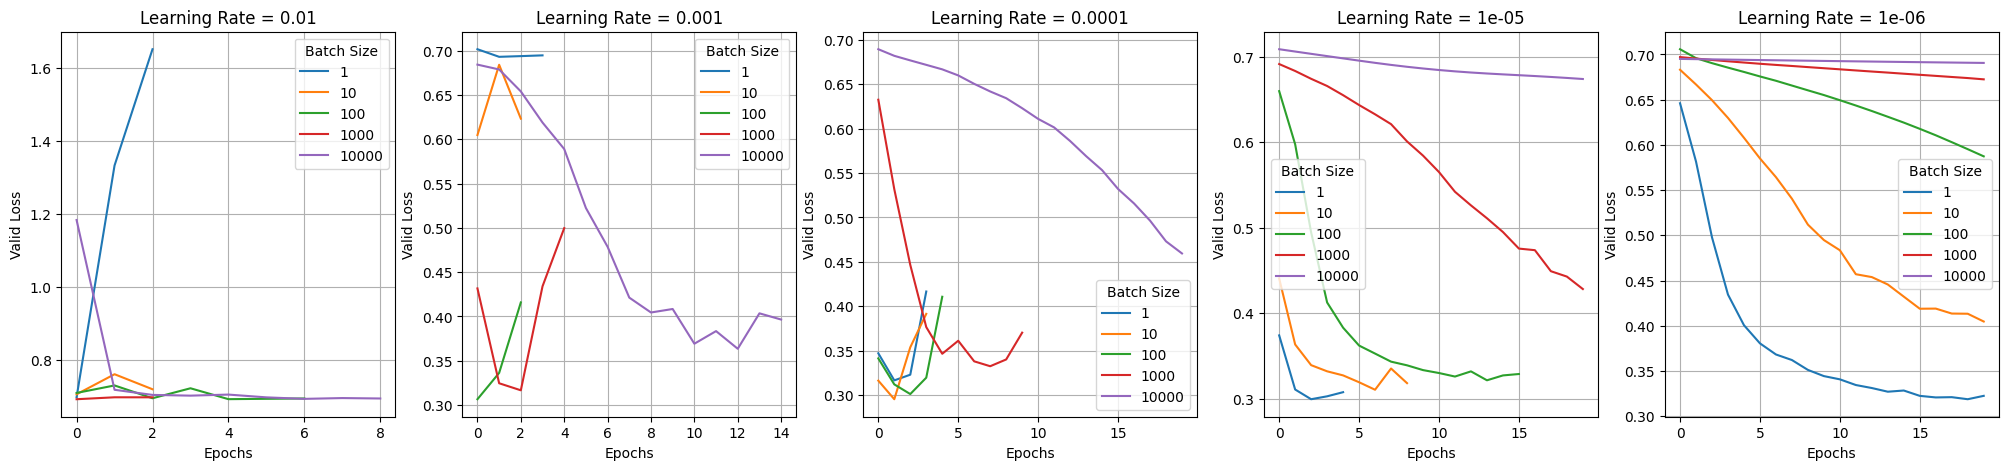

In [5]:
fig, axes = plt.subplots(1, 5, figsize=(25,5))
for lr, ax in zip(params['lr'], axes.ravel()):
    for batch_size in params['batch_size']:
        log = pd.read_pickle(fr'bert-tiny_{lr}_{batch_size}.pkl')
        ax.plot(log['valid_loss'])
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Valid Loss')
        ax.legend(params['batch_size'], title='Batch Size')
        ax.set_title(f'Learning Rate = {lr}')
        ax.grid()
plt.show()

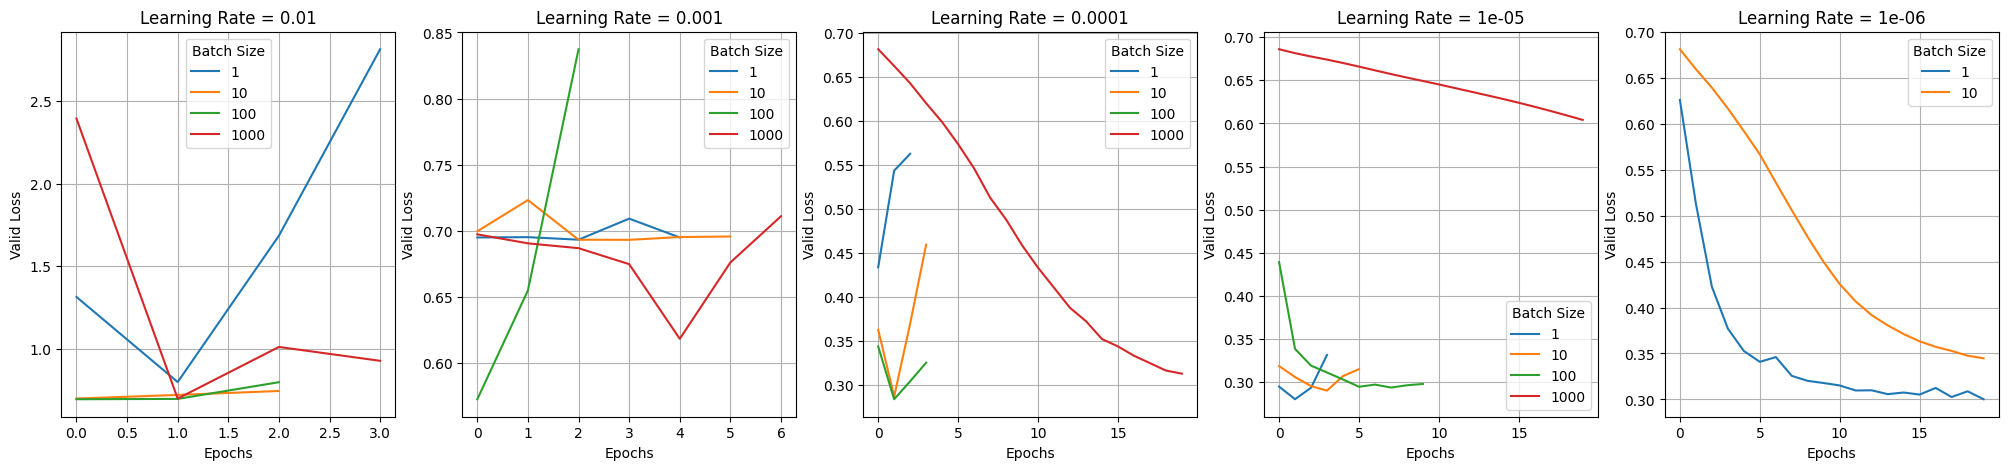

In [6]:
fig, axes = plt.subplots(1, 5, figsize=(25,5))
for lr, ax in zip(params['lr'], axes.ravel()):
    for batch_size in params['batch_size']:
        ax.grid()
        if batch_size == 1000: continue
        if lr == 1e-6 and (batch_size == 1 or batch_size == 10000): continue
        log = pd.read_pickle(fr'bert-mini_{lr}_{batch_size}.pkl')
        ax.plot(log['valid_loss'])
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Valid Loss')
        ax.legend(params['batch_size'], title='Batch Size')
        ax.set_title(f'Learning Rate = {lr}')
        
plt.show()

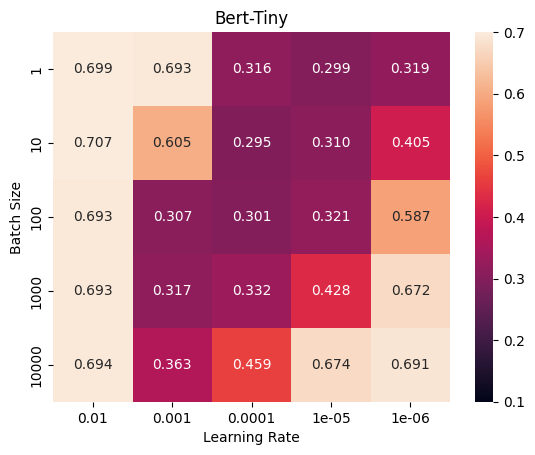

In [7]:
best_loss = np.zeros((5, 5))
for lr_idx, lr in enumerate(params['lr']):
    for batch_idx, batch_size in enumerate(params['batch_size']):
        log = pd.read_pickle(fr'bert-tiny_{lr}_{batch_size}.pkl')
        best_loss[batch_idx, lr_idx] = min(log['valid_loss'])

data = pd.DataFrame(best_loss, index=params['batch_size'], columns=params['lr'])
sns.heatmap(data, annot=True, vmin=0.1, vmax=0.7, fmt='.3f')
plt.ylabel('Batch Size')
plt.xlabel('Learning Rate')
plt.title('Bert-Tiny')
plt.show()

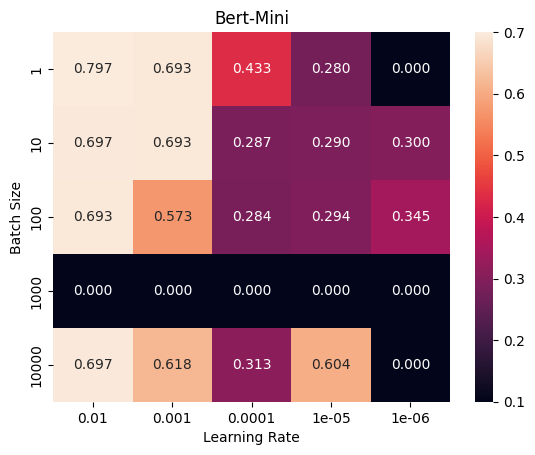

In [8]:
best_loss = np.zeros((5, 5))
for lr_idx, lr in enumerate(params['lr']):
    for batch_idx, batch_size in enumerate(params['batch_size']):
        if batch_size == 1000: continue
        if lr == 1e-6 and (batch_size == 1 or batch_size == 10000): continue
        log = pd.read_pickle(fr'bert-mini_{lr}_{batch_size}.pkl')
        best_loss[batch_idx, lr_idx] = min(log['valid_loss'])

data = pd.DataFrame(best_loss, index=params['batch_size'], columns=params['lr'])
sns.heatmap(data, annot=True, vmin=0.1, vmax=0.7, fmt='.3f')
plt.ylabel('Batch Size')
plt.xlabel('Learning Rate')
plt.title('Bert-Mini')
plt.show()

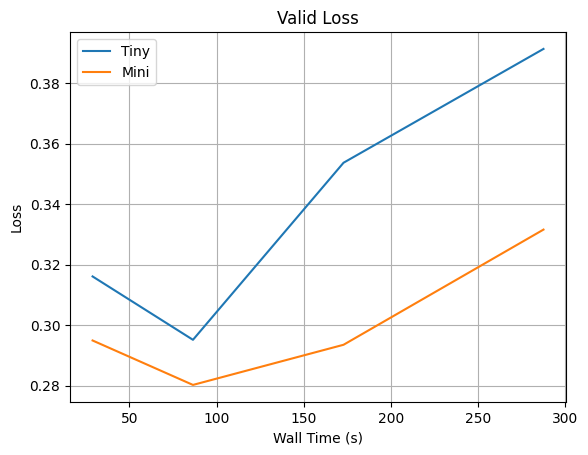

In [9]:
best_tiny = pd.read_pickle(fr'bert-tiny_0.0001_10.pkl')
time_tiny = best_tiny['wall_time']
for i in range(len(time_tiny)-1):
    time_tiny[i+1] = time_tiny[i] + time_tiny[i+1]
    
best_mini = pd.read_pickle(fr'bert-mini_1e-05_1.pkl')
time_mini = best_tiny['wall_time']
for i in range(len(time_mini)-1):
    time_mini[i+1] = time_mini[i] + time_mini[i+1]

plt.plot(time_tiny, best_tiny['valid_loss'], label='Tiny')
plt.plot(time_mini, best_mini['valid_loss'], label='Mini')
plt.legend()
plt.title('Valid Loss')
plt.xlabel('Wall Time (s)')
plt.ylabel('Loss')
plt.grid()
plt.show()

No mini, os valores 0 foram arquivos que corromperam. Não teve tempo para treinar o Medium!